<img src="../images/headers/nb_3.svg"  width="1080" height="220">

# Import Section

In [1]:
import multiprocessing

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.random import sample_without_replacement
from skopt import BayesSearchCV
from xgboost import XGBClassifier, plot_importance

from roaf import parameterization

In [2]:
%matplotlib inline
plt.style.use("dark_background")
plt.set_cmap("Dark2")
sns.set_palette("Dark2")

<Figure size 640x480 with 0 Axes>

In [3]:
FAST_EXECUTION = False
MAX_SAMPLE_SIZE = None
N_PLOT = 15
N_CV_STANDARD = 5
N_CV = N_CV_STANDARD
N_PERMUTATION_REPETITIONS = None
N_RANDOM_FOREST_ESTIMATORS = None

In [4]:
# The reduction factor gives a hint on how much longer the standard execution would take than the
# execution with the current parameters. It does not take into account non-linear behaviour.
REDUCTION_FACTOR = N_CV_STANDARD / N_CV

In [5]:
df = pd.read_parquet("../data/processed/df_by_user.parquet")

# Data Preprocessing for Machine Learning

In [6]:
df_ml = (
    df.select_dtypes(include=np.number)
    .drop(columns=["accident_id", "accident_id_y"])
    .dropna(axis=1, how="any")
)

In [7]:
df_ml = pd.get_dummies(
    data=df_ml,
    columns=[
        "daylight",
        "built_up_area",
        "intersection_category",
        "weather",
        "collision_category",
        "road_admin_category",
        "traffic_regime",
        "reserved_lane",
        "plane_layout",
        "surface_condition",
        "infrastructure",
        "location",
        "is_weekend",
        "role",
    ],
)

In [8]:
features = df_ml.drop(columns="severity")
feature_columns = features.columns
target = df_ml["severity"]
random_under_sampler = RandomUnderSampler()
features, target = random_under_sampler.fit_resample(X=features, y=target)

MAX_SAMPLE_SIZE, REDUCTION_FACTOR = parameterization.set_parameter(
    MAX_SAMPLE_SIZE,
    std_value=100_000_000,
    fast_value=10_000,
    fast_execution=FAST_EXECUTION,
    reduction_factor=REDUCTION_FACTOR,
)

sample_size = len(target)
if sample_size > MAX_SAMPLE_SIZE:
    sample_idx = sample_without_replacement(
        n_population=sample_size, n_samples=MAX_SAMPLE_SIZE, random_state=0
    )
    features = features.iloc[sample_idx]
    target = target.iloc[sample_idx]

print(sample_size)

28491


In [9]:
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.2,
    random_state=0,
)

In [11]:
# Reconvert the features to DataFrames in order to keep the feature names
X_train = pd.DataFrame(data=X_train)
X_test = pd.DataFrame(data=X_test)
X_train.columns = feature_columns
X_test.columns = feature_columns

The preprocessed and splitted dataset will be exported to parquet so that it can be used in
notebook 4 (artificial neural networks). Parquet is used again as the file format for its
low requirements regarding disk space.

In [12]:
TRAIN_FILENAME = "Xy_train"
TEST_FILENAME = "Xy_test"

if FAST_EXECUTION:
    TRAIN_FILENAME = "TESTING_" + TRAIN_FILENAME
    TEST_FILENAME = "TESTING_" + TEST_FILENAME

Xy_train = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
Xy_test = pd.concat([X_test, y_test.reset_index(drop=True)], axis=1)

Xy_train.to_parquet("../data/processed/" + TRAIN_FILENAME + ".parquet")
Xy_test.to_parquet("../data/processed/" + TEST_FILENAME + ".parquet")

# XGBoost

In [13]:
N_CV, REDUCTION_FACTOR = parameterization.set_parameter(
    N_CV,
    std_value=20,
    fast_value=2,
    fast_execution=FAST_EXECUTION,
    reduction_factor=REDUCTION_FACTOR,
)

xgb_clf = XGBClassifier(n_jobs=multiprocessing.cpu_count() // 2)

param_grid = {
    "max_depth": [2, 4, 6],
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
}


bayes_search = BayesSearchCV(
    xgb_clf, param_grid, cv=N_CV, n_jobs=2, n_iter=4, verbose=3
)
bayes_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Fitting 5 folds for each of 1 candidates, totalling 5 fits


Fitting 5 folds for each of 1 candidates, totalling 5 fits


Fitting 5 folds for each of 1 candidates, totalling 5 fits


BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None...
                                      max_cat_threshold=None,
                                      max_cat_to_onehot=None,
                                      max_delta_step=None, max_depth=None,
                                      max_leaves=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      n_estimators=100, n_jobs=4,
                                      num_parallel_tree=None, predictor=None,
                                      random_state=None, ...),
              n_iter=4, n_jobs=2,
              search_spaces={'learning_rate': [0.05, 0.1],
                             'max_depth': [2, 4, 6],
                             'n_estimators': [100, 200]},
              verbose=3)

In [14]:
best_xgb = bayes_search.best_estimator_
y_pred = best_xgb.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.54      0.74      0.62      1869
           1       0.53      0.27      0.36      1906
           2       0.64      0.72      0.68      1924

    accuracy                           0.57      5699
   macro avg       0.57      0.58      0.55      5699
weighted avg       0.57      0.57      0.55      5699



When interpreting precision and recall for machine learning models, it is important to keep in
mind, that the test data is balanced while the real-world data is not. That means, that we would
expect an accuracy of 0.33 for a random guess.

The model does a good job predicting deadly injuries. Unharmed persons are detected with a high
recall but with lower precision. It shows a lower performance for injured persons. Here,
especially the recall is very low.

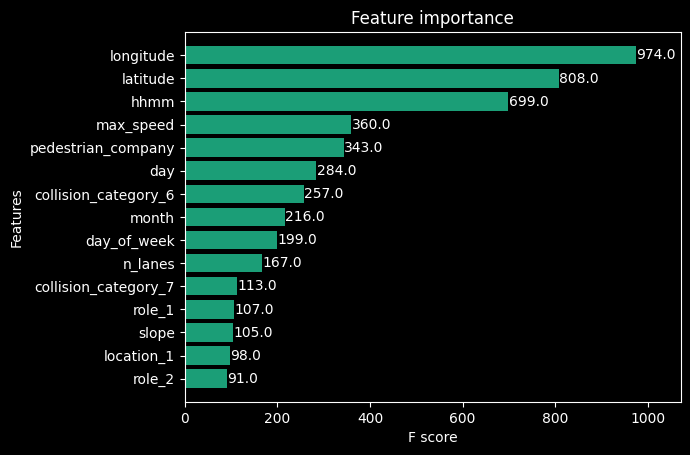

In [15]:
p = plot_importance(best_xgb, max_num_features=N_PLOT, height=0.8, grid="off")
p.grid(False)

The feature importance plot enables us to identify the most important features used by XGBoost
for the classification problem.
It seems like the location (represented by longitude and latitude) has the highest importance
in this case.

# Random Forest

In [16]:
N_RANDOM_FOREST_ESTIMATORS, REDUCTION_FACTOR = parameterization.set_parameter(
    N_RANDOM_FOREST_ESTIMATORS,
    std_value=100,
    fast_value=10,
    fast_execution=FAST_EXECUTION,
    reduction_factor=REDUCTION_FACTOR,
)

random_forest_clf = RandomForestClassifier(n_estimators=N_RANDOM_FOREST_ESTIMATORS)
random_forest_clf.fit(X_train, y_train)
y_pred_rf = random_forest_clf.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred_rf))

              precision    recall  f1-score   support

           0       0.52      0.64      0.57      1869
           1       0.47      0.34      0.39      1906
           2       0.64      0.68      0.66      1924

    accuracy                           0.55      5699
   macro avg       0.54      0.55      0.54      5699
weighted avg       0.55      0.55      0.54      5699



## Interpretation with Means of Permutation Importance
Random Forests can be interpreted with impurity-based feature importance, but this approach
has some downsides.
I will therefore use permutation feature importance to analyze the model. For this, I will
calculate the feature importance weights for both the training and the test set and compare them.
Those features that show a high # difference # between the calculated values for training and
test set are considered to be causal for overfitting.

In [17]:
# The permutation performance takes a while to compute.
N_PERMUTATION_REPETITIONS, REDUCTION_FACTOR = parameterization.set_parameter(
    N_PERMUTATION_REPETITIONS,
    std_value=10,
    fast_value=1,
    fast_execution=FAST_EXECUTION,
    reduction_factor=REDUCTION_FACTOR,
)

r_train = permutation_importance(
    random_forest_clf,
    X_train,
    y_train,
    n_repeats=N_PERMUTATION_REPETITIONS,
    random_state=0,
)
r_test = permutation_importance(
    random_forest_clf,
    X_test,
    y_test,
    n_repeats=N_PERMUTATION_REPETITIONS,
    random_state=0,
)

In [18]:
importances_mean_df = pd.DataFrame(index=feature_columns)
importances_std_df = pd.DataFrame(index=feature_columns)

importances_mean_df["train"] = r_train.importances_mean
importances_mean_df["test"] = r_test.importances_mean

importances_std_df["train"] = r_train.importances_std
importances_std_df["test"] = r_test.importances_std

importances_mean_df["train_test_diff"] = abs(
    importances_mean_df["test"] - importances_mean_df["train"]
)
importances_mean_df.sort_values(by="train_test_diff", ascending=False, inplace=True)
importances_mean_df.drop(columns=["train_test_diff"], inplace=True)
importances_std_df = importances_std_df.reindex_like(importances_mean_df)

Text(0, 0.5, 'feature')

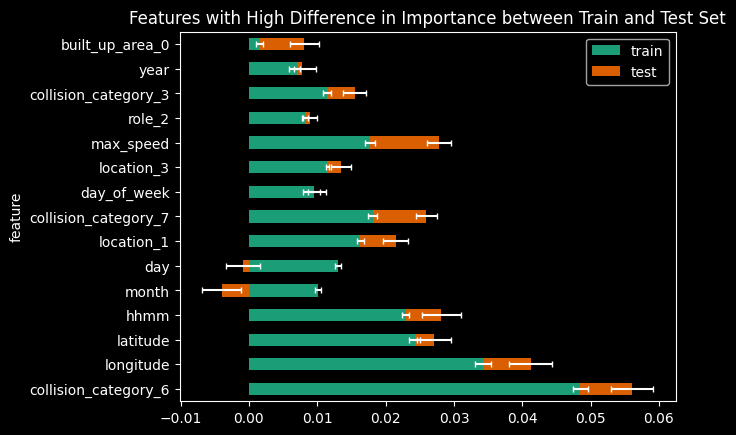

In [19]:
importances_mean_df[["train", "test"]].head(N_PLOT).plot(
    kind="barh", capsize=2, xerr=importances_std_df.head(N_PLOT), stacked=True
)
plt.title("Features with High Difference in Importance between Train and Test Set")
plt.xlabel("")
plt.ylabel("feature")

<Axes: xlabel='train'>

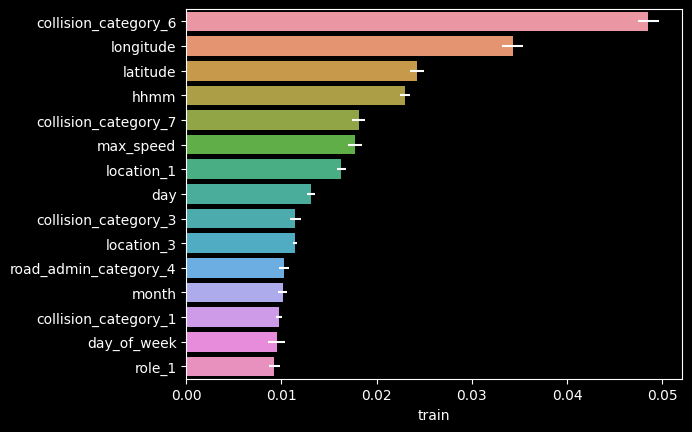

In [20]:
importances_mean_df.sort_values("train", ascending=False, inplace=True)
importances_std_df = importances_std_df.reindex_like(importances_mean_df)
sns.barplot(
    data=importances_mean_df.head(N_PLOT),
    x="train",
    y=importances_mean_df.head(N_PLOT).index.values,
    xerr=importances_std_df["train"].head(N_PLOT),
    capsize=1.0,
    ecolor="white",
)